Use npgamma to compare HN Case 7 dose data. See https://github.com/SimonBiggs/npgamma/blob/master/Module%20usage%203D.ipynb

In [1]:
import dicom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from npgamma import calc_gamma

In [4]:
dcm_ref = dicom.read_file("Case7_dose_AAA.dcm")
dcm_evl = dicom.read_file("Case7_dose_Dm.dcm")

In [5]:
# The x, y, and z defined here have not been sufficiently verified
# They do not necessarily match either what is within Dicom nor what is within your
# TPS. Please verify these and see if they are what you expect them to be.

# If these functions are incorrect or there is a better choice of dimension definitions 
# please contact me by creating an issue within the github repository:
#   https://github.com/SimonBiggs/npgamma/issues

# If you are able to validate these functions please contact me in the same way.


# Imports the dose in matplotlib format, with the following index mapping:
#   i = y
#   j = x
#   k = z

# Therefore w
def load_dose_from_dicom(dcm):
    """Imports the dose in matplotlib format, with the following index mapping:
        i = y
        j = x
        k = z
    
    Therefore when using this function to have the coords match the same order,
    ie. coords_reference = (y, x, z)
    """
    pixels = np.transpose(
        dcm.pixel_array, (1, 2, 0))
    dose = pixels * dcm.DoseGridScaling

    return dose


def load_xyz_from_dicom(dcm):
    """Although this coordinate pull from Dicom works in the scenarios tested
    this is not an official x, y, z pull. It needs further confirmation.
    """
    resolution = np.array(
        dcm.PixelSpacing).astype(float)
    # Does the first index match x? 
    # Haven't tested with differing grid sizes in x and y directions.
    dx = resolution[0]

    # The use of dcm.Columns here is under question
    x = (
        dcm.ImagePositionPatient[0] +
        np.arange(0, dcm.Columns * dx, dx))

    # Does the second index match y? 
    # Haven't tested with differing grid sizes in x and y directions.
    dy = resolution[1]
    
    # The use of dcm.Rows here is under question
    y = (
        dcm.ImagePositionPatient[1] +
        np.arange(0, dcm.Rows * dy, dy))
    
    # Is this correct?
    z = (
        np.array(dcm.GridFrameOffsetVector) +
        dcm.ImagePositionPatient[2])

    return x, y, z


dose_reference = load_dose_from_dicom(dcm_ref)
dose_evaluation = load_dose_from_dicom(dcm_evl)

x_reference, y_reference, z_reference = load_xyz_from_dicom(dcm_ref)
x_evaluation, y_evaluation, z_evaluation = load_xyz_from_dicom(dcm_evl)

In [6]:
# Input coordinates need to match the same order as the dose grid in 
# index reference order.

coords_reference = (
    y_reference, x_reference, z_reference)

coords_evaluation = (
    y_evaluation, x_evaluation, z_evaluation)

In [7]:
distance_threshold = 3
distance_step_size = distance_threshold / 10

dose_threshold = 0.03 * np.max(dose_reference)
lower_dose_cutoff = np.max(dose_reference) * 0.2
maximum_test_distance = distance_threshold * 2
max_concurrent_calc_points = 10000000

In [8]:
gamma = calc_gamma(
    coords_reference, dose_reference,
    coords_evaluation, dose_evaluation,
    distance_threshold, dose_threshold,
    lower_dose_cutoff=lower_dose_cutoff, 
    distance_step_size=distance_step_size,
    maximum_test_distance=maximum_test_distance,
    max_concurrent_calc_points=max_concurrent_calc_points)

In [9]:
valid_gamma = gamma[~np.isnan(gamma)]
valid_gamma[valid_gamma > 2] = 2

(0, 2)

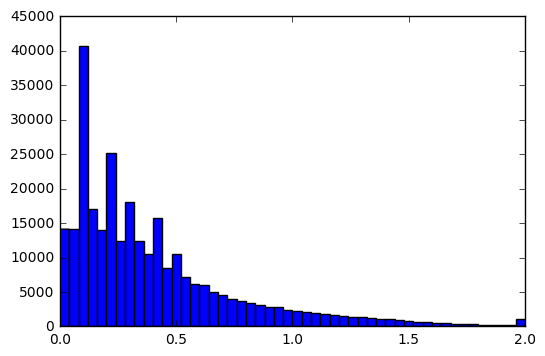

In [10]:
plt.hist(valid_gamma, 50);
plt.xlim([0,2])

In [11]:
np.sum(valid_gamma <= 1) / len(valid_gamma)

0.9152553510103717

In [12]:
relevant_slice = (
    np.max(dose_evaluation, axis=(0, 1)) > 
    lower_dose_cutoff)
slice_start = np.max([
        np.where(relevant_slice)[0][0], 
        0])
slice_end = np.min([
        np.where(relevant_slice)[0][-1], 
        len(z_evaluation)])

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in greater


Slice = -141.25


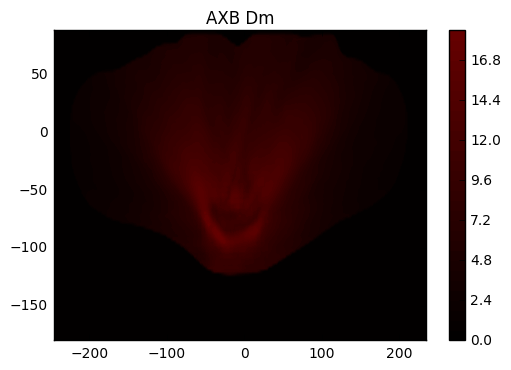

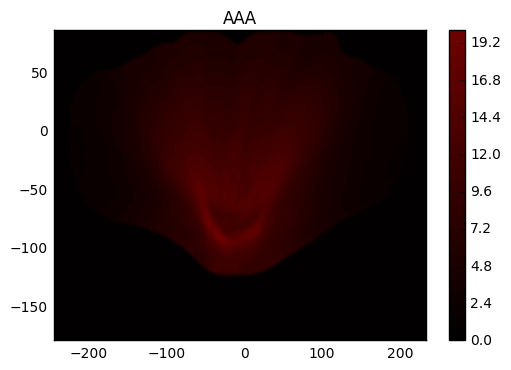

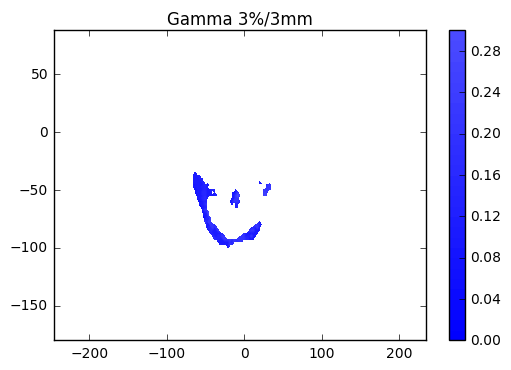



Slice = -128.75


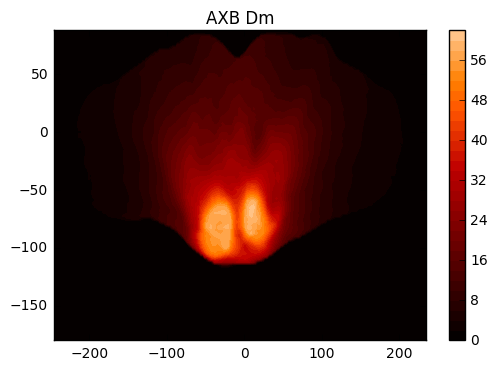

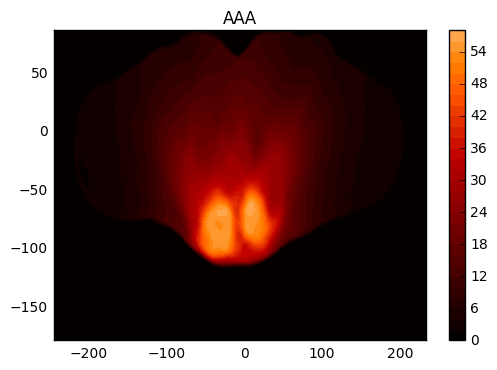

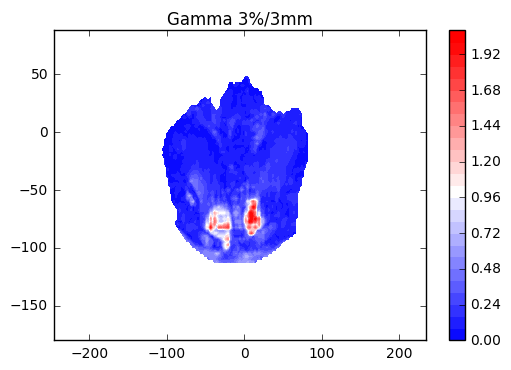



Slice = -116.25


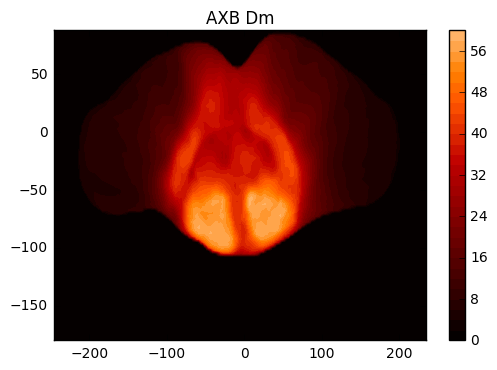

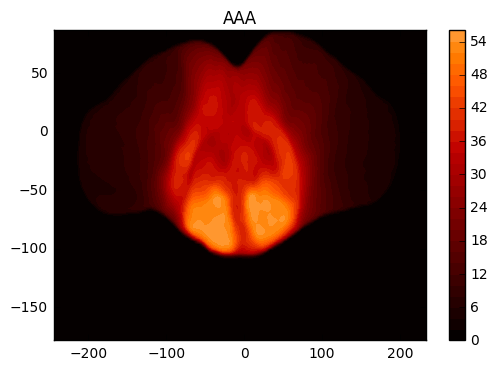

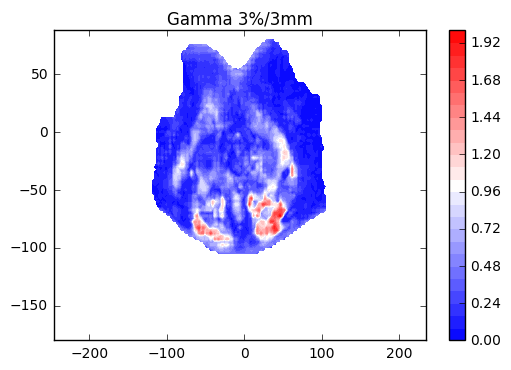



Slice = -103.75


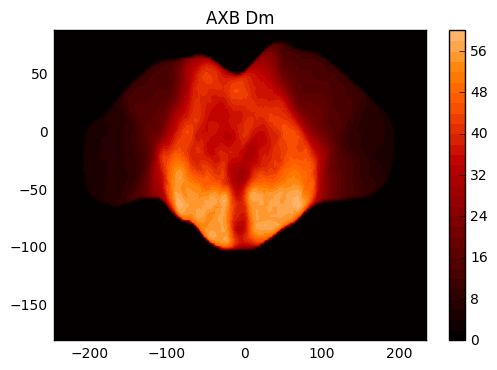

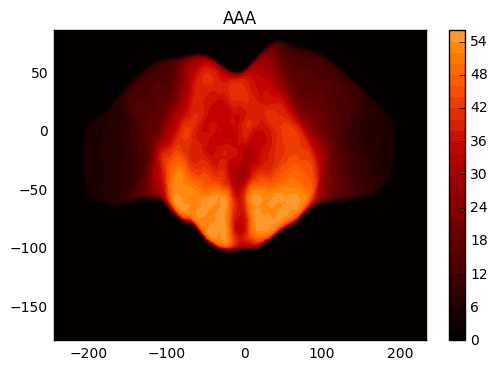

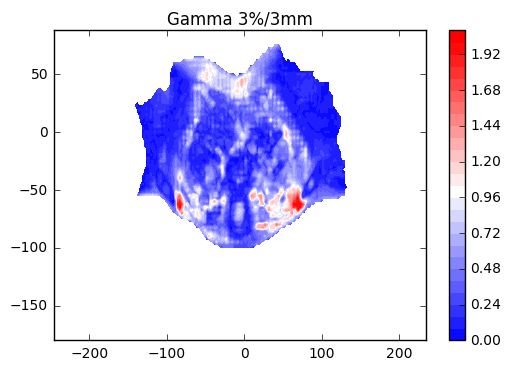



Slice = -91.25


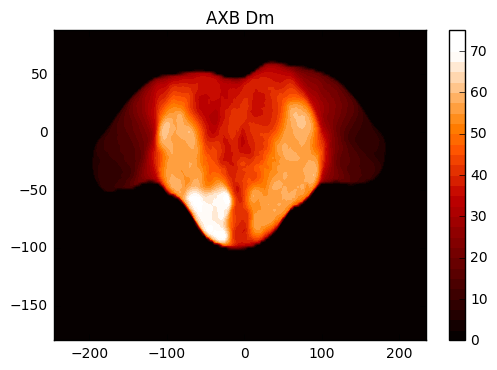

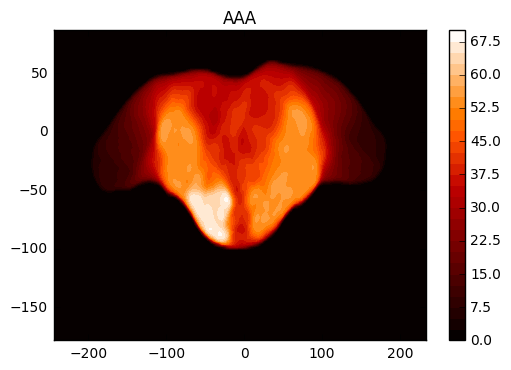

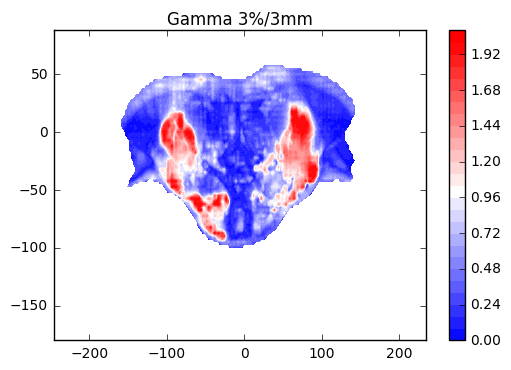



Slice = -78.75


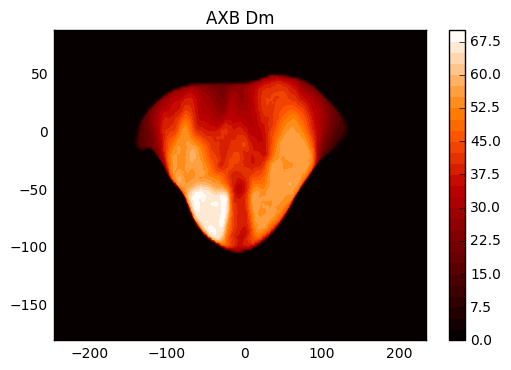

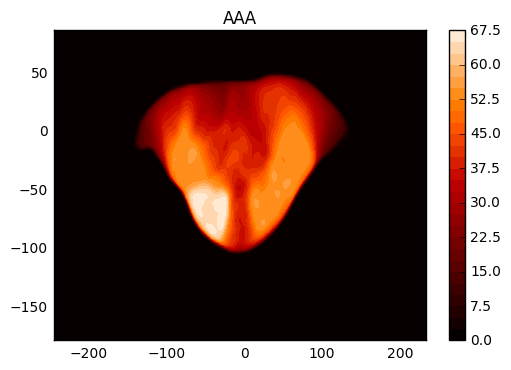

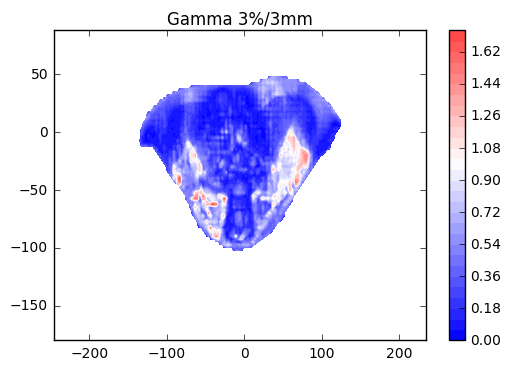



Slice = -66.25


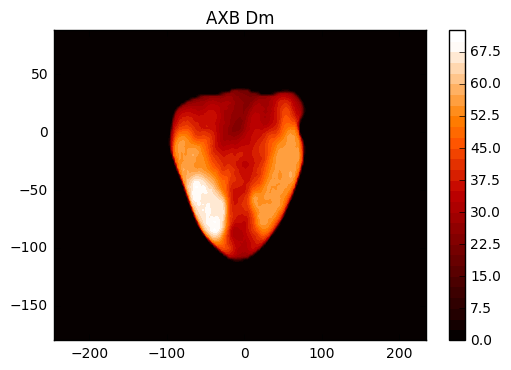

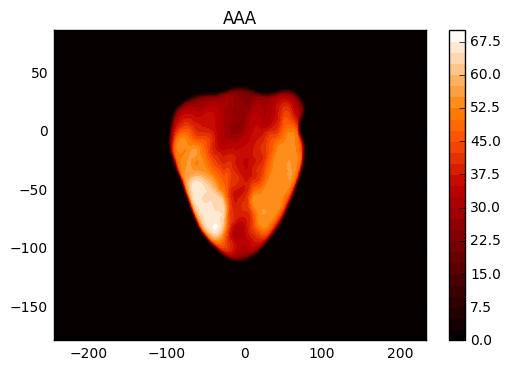

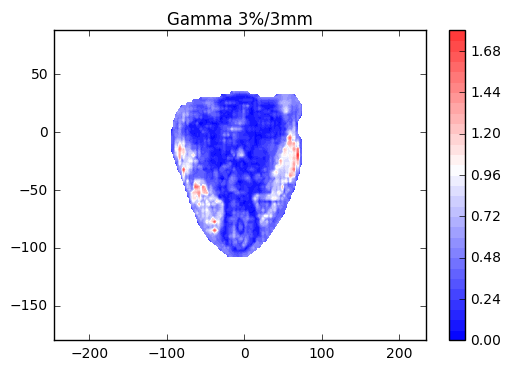



Slice = -53.75


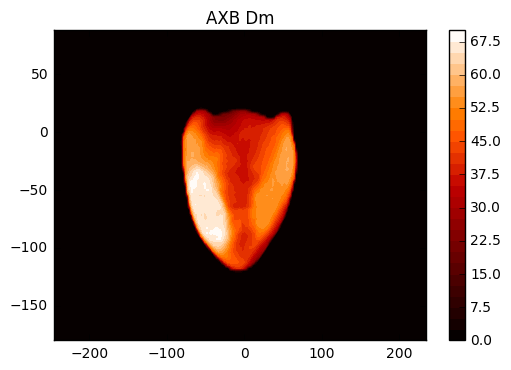

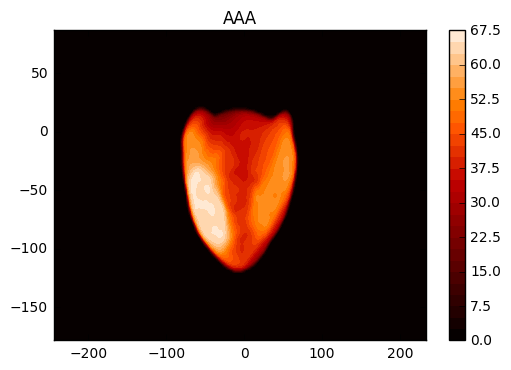

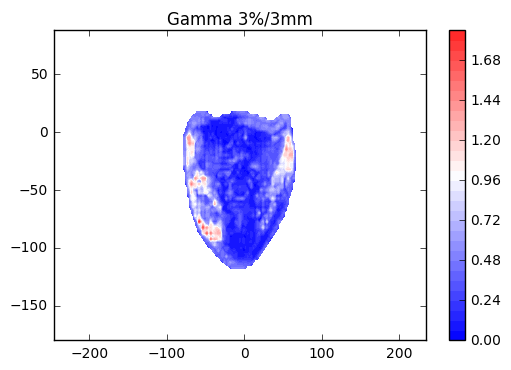



Slice = -41.25


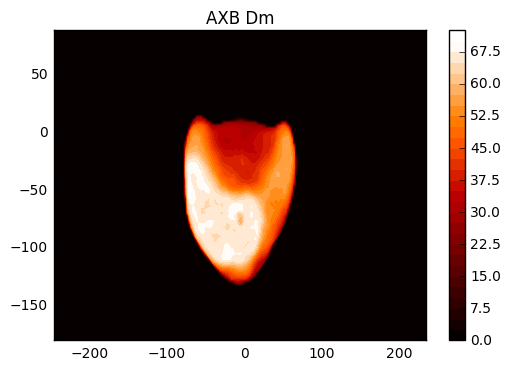

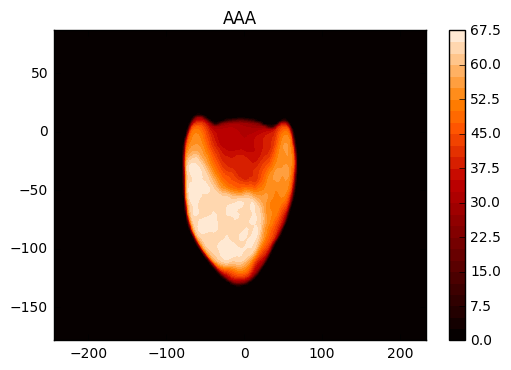

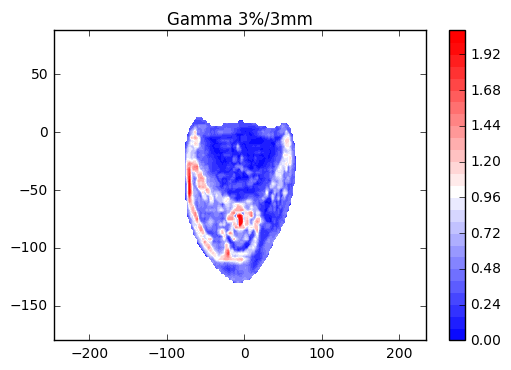



Slice = -28.75


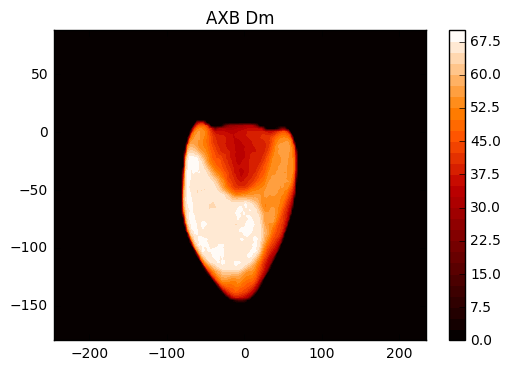

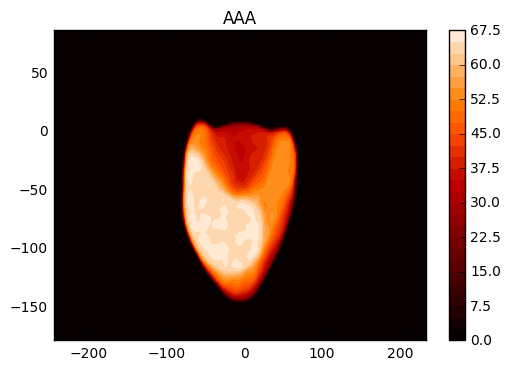

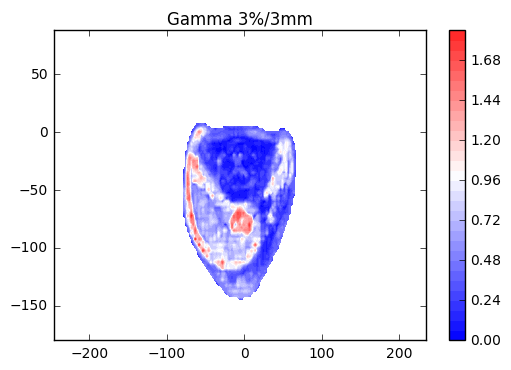



Slice = -16.25


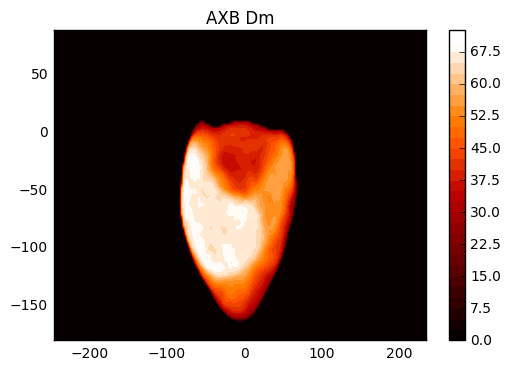

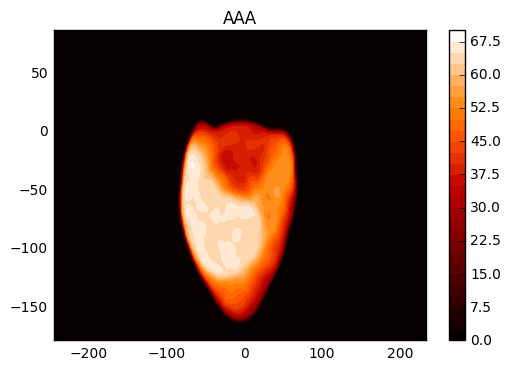

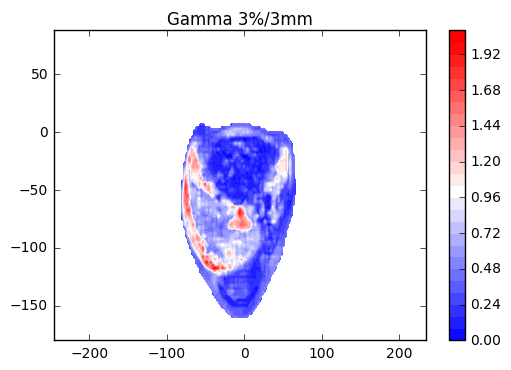



Slice = -3.75


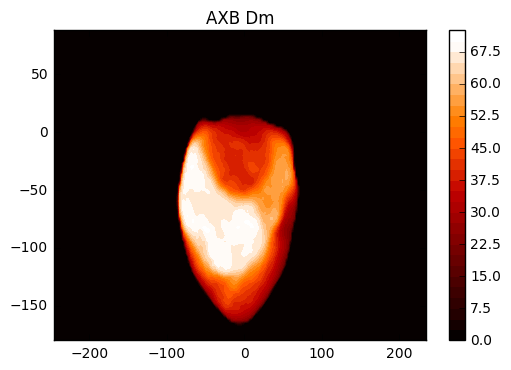

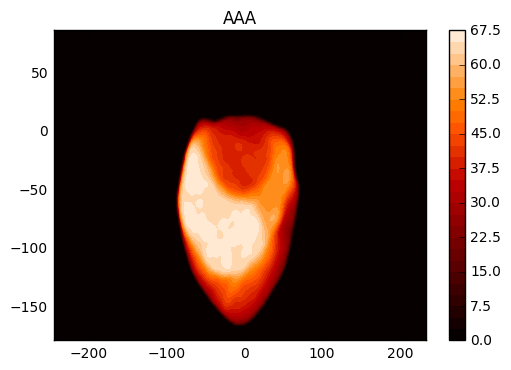

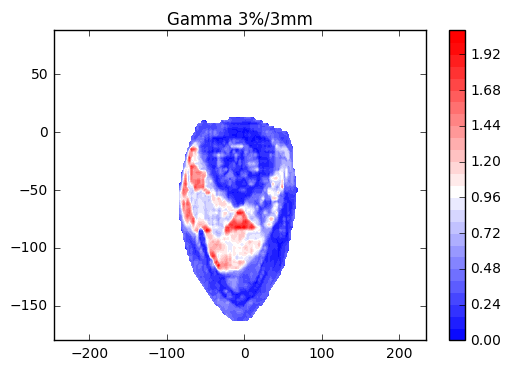



Slice = 8.75


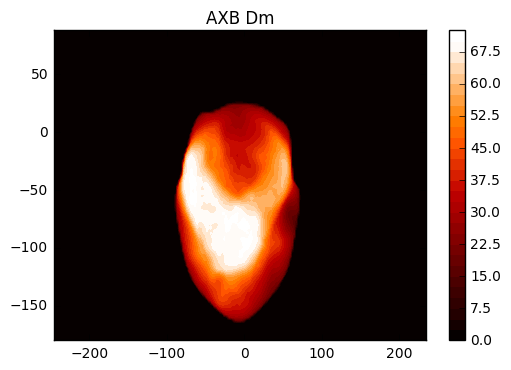

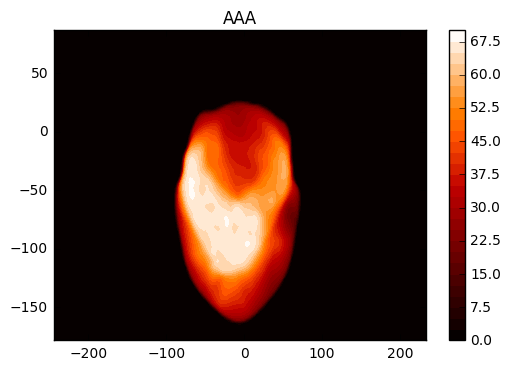

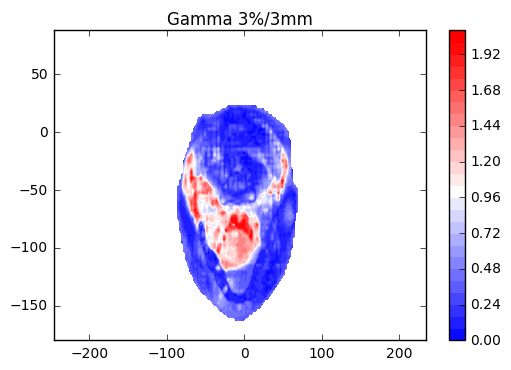



Slice = 21.25


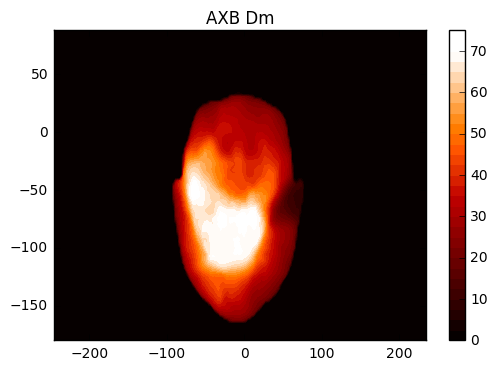

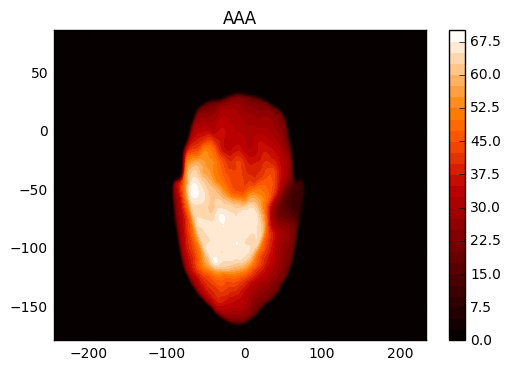

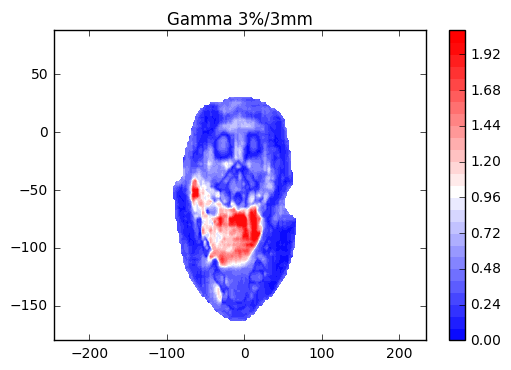



Slice = 33.75


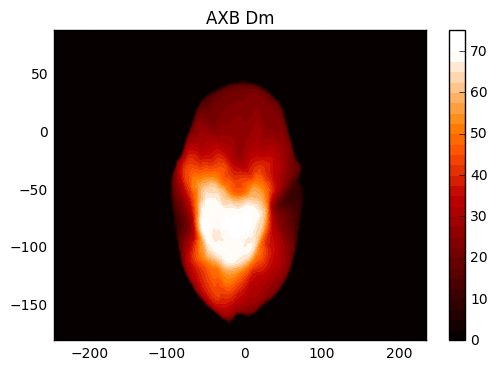

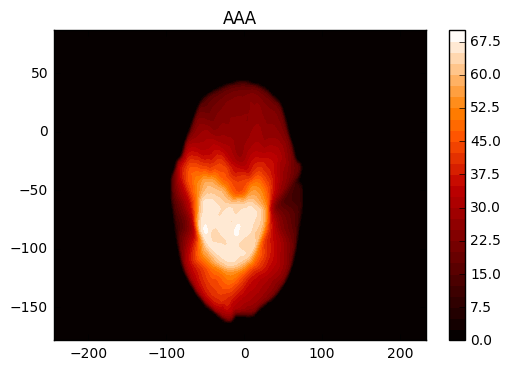

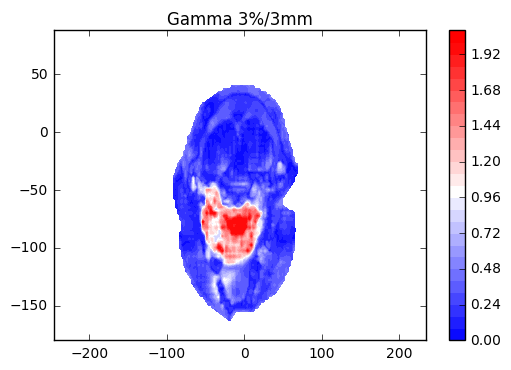



Slice = 46.25


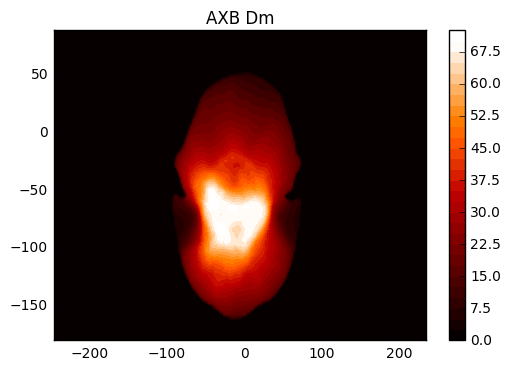

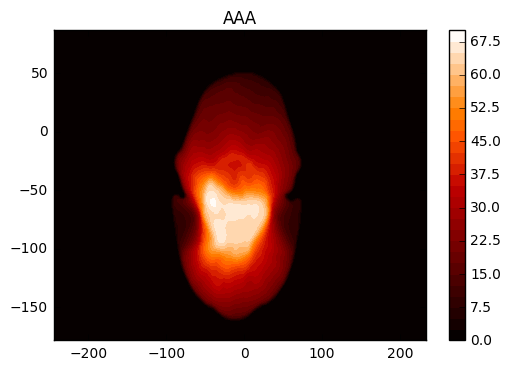

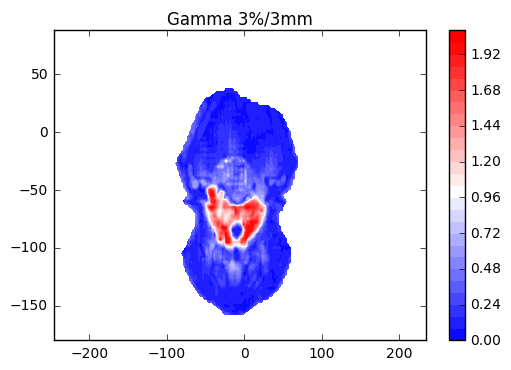



Slice = 58.75


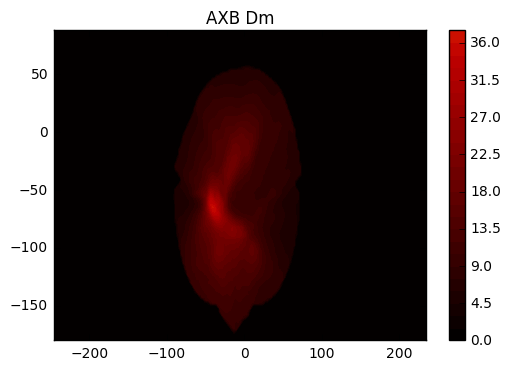

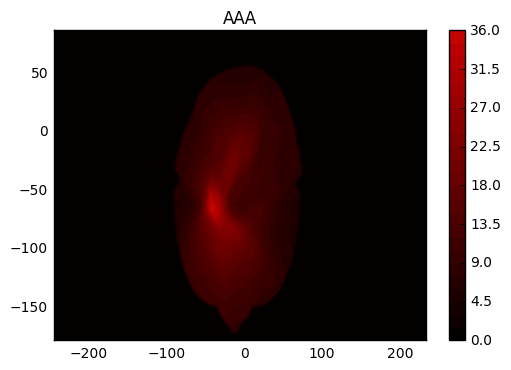

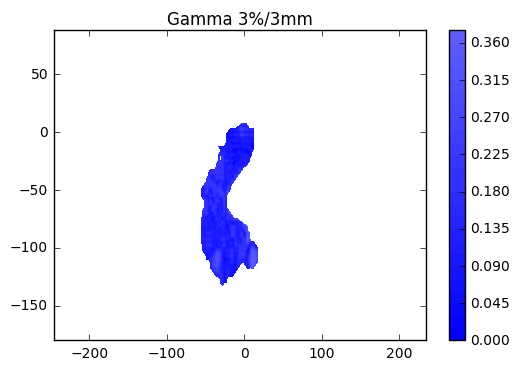

In [29]:
max_ref_dose = np.max(dose_reference)

cut_off_gamma = gamma.copy()
greater_than_2_ref = (cut_off_gamma > 2) & ~np.isinf(cut_off_gamma)
cut_off_gamma[greater_than_2_ref] = 2

toplot = z_evaluation[slice_start:slice_end:5]#

for z_i in toplot:
    i = np.where(z_i == z_evaluation)[0][0]
    j = np.where(z_i == z_reference)[0][0]
    print("======================================================================")
    print("Slice = {0}".format(z_i))  
   
    plt.contourf(
        x_evaluation, y_evaluation, dose_evaluation[:, :, j], 30, 
        vmin=0, vmax=max_ref_dose, cmap=plt.get_cmap('gist_heat'))
    plt.title("AXB Dm")  # Evaluation -
    plt.colorbar()
    plt.show()
    
    plt.contourf(
        x_reference, y_reference, dose_reference[:, :, j], 30, 
        vmin=0, vmax=max_ref_dose, cmap=plt.get_cmap('gist_heat'))
    plt.title("AAA")  # Reference - 
    plt.colorbar()
    plt.show()
    
    plt.contourf(
        x_evaluation, y_evaluation, cut_off_gamma[:, :, i], 30, 
        vmin=0, vmax=2, cmap=plt.get_cmap('bwr'))
    plt.title("Gamma 3%/3mm")    
    plt.colorbar()  
    plt.show()
    
    print("\n")

In [30]:
def cast_gamma_as_RD(dcm, gamma, coords):
    gamma = np.transpose(gamma, (2, 1, 0))
    if int(dcm.Rows) != int(gamma.shape[1]) or int(dcm.Columns) != int(gamma.shape[2]) or int(dcm.NumberOfFrames) != int(gamma.shape[0]):
        dcm.Rows = gamma.shape[1]
        dcm.Columns = gamma.shape[2]
        dcm.NumberOfFrames = gamma.shape[0]
        dcm.ImagePositionPatient = map(str, [coords[0][0], coords[1][0], coords[2][0]])
        dcm.GridFrameOffsetVector = map(str, [x - coords[2][0] for x in coords[2].tolist()])

    # set dose type and pixel representation
    dcm.DoseType = 'ERROR'
    # convert to uint32 using dcm.DoseGridScaling
    unwVal = 0.0  # value to set unwanted elements to
    gamma[gamma < 0] = unwVal  # get rid of negative values
    gamma[np.isinf(gamma)] = unwVal  # set inf to value
    gamma = (gamma / float(dcm.DoseGridScaling)).astype('uint32')

    # PixelData
    dcm.PixelData = gamma.tostring()

    #update UID
    dcm.SOPInstanceUID = dicom.UID.generate_uid()

    return dcm

In [33]:
gamma_as_dcm = cast_gamma_as_RD(dcm_ref, gamma, coords_reference)

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in less


In [35]:
gamma_as_dcm.save_as("gamma_as_dcm.dcm")